In [1]:
import os
import matplotlib.pyplot as plt  
import numpy as np 
import tensorflow as tf  
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.datasets import imdb
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras import regularizers
from keras.utils.vis_utils import plot_model
from keras.layers import *
from keras.models import *
from keras import backend as K
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential



os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

2023-03-21 20:01:35.421107: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 20:01:37.216118: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
n_unique_words = 10000
(x_train, y_train),(x_test, y_test) = imdb.load_data(num_words=n_unique_words)

In [3]:
maxlen = 200
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [4]:
class attention(Layer):
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences

        super(attention,self).__init__()

    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),initializer="normal")
        self.b= self.add_weight(name="att_bias", shape=(input_shape[1],1),initializer="normal")
        self.b= self.add_weight(name="att_bias", shape=(input_shape[1],1))        
        super(attention,self).build(input_shape)


    def call(self, x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        if self.return_sequences:
            return output
        return K.sum(output, axis=1)

In [5]:
model = Sequential()
model.add(Embedding(n_unique_words, 128, input_length=maxlen))
model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(attention(return_sequences=False)) # receive 3D and output 3D
model.add(Dropout(0.5))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

2023-03-21 20:02:09.259624: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 20:02:13.526364: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30958 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:5e:00.0, compute capability: 7.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 200, 256)         198144    
 l)                                                              
                                                                 
 attention (attention)       (None, 256)               456       
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 16)                4112      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                        

In [6]:
history=model.fit(x_train, y_train,batch_size=32,epochs=10)
print(history.history['loss'])
print(history.history['accuracy']) 
# model.save(f"/work/cse479/apramani/model_gru_4.h5")

# test data
loss, accuracy = model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)


Epoch 1/10


2023-03-21 20:02:19.996431: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /common/nimbus/apramani/tensorflow-env/lib/python3.9/site-packages/tensorflow/python/../../../../libcublas.so.11: undefined symbol: cublasGetSmCountTarget


782/782 [==============================] - 20s 17ms/step - loss: 0.4076 - accuracy: 0.8073
Epoch 2/10
782/782 [==============================] - 13s 17ms/step - loss: 0.2352 - accuracy: 0.9124
Epoch 3/10
782/782 [==============================] - 13s 17ms/step - loss: 0.1664 - accuracy: 0.9416
Epoch 4/10
782/782 [==============================] - 13s 17ms/step - loss: 0.1148 - accuracy: 0.9628
Epoch 5/10
782/782 [==============================] - 13s 17ms/step - loss: 0.0795 - accuracy: 0.9762
Epoch 6/10
782/782 [==============================] - 13s 17ms/step - loss: 0.0582 - accuracy: 0.9838
Epoch 7/10
782/782 [==============================] - 13s 17ms/step - loss: 0.0431 - accuracy: 0.9888
Epoch 8/10
782/782 [==============================] - 13s 17ms/step - loss: 0.0382 - accuracy: 0.9900
Epoch 9/10
782/782 [==============================] - 13s 17ms/step - loss: 0.0315 - accuracy: 0.9920
Epoch 10/10
782/782 [==============================] - 13s 17ms/step - loss: 0.0289 - accurac

In [7]:
Y_pred = model.predict(x_test)
Y_pred = Y_pred.ravel() 
y_pred_binary = np.where(Y_pred >= 0.5, 1, 0)



782/782 [==============================] - 6s 6ms/step


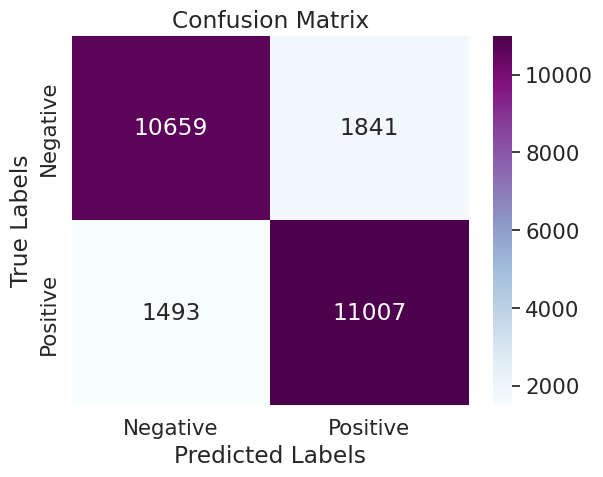

In [9]:
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred_binary)
tn, fp, fn, tp = conf_matrix.ravel()

sns.set(font_scale=1.4)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='BuPu', 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()